# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2019/20

# Project 3 - Classification/Regression

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Tasks **1 to 4** should be done by **all** groups **BUT**
    * In Tasks **2 and 3** the number of classifiers/regressors to use is **`X` = 2, 3 and 4**  for groups of 1, 2 and 3 students, respectively.
    * In Task **4**, groups of 1, 2 and 3 students should try 1, 2 and 3 ensemble approaches, respectively.

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of June, 9th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project3.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/). You are also allowed to use [Orange3](https://orange.biolab.si).**

The dataset to be analysed is **`ModifiedHousePrices.csv`**, a modified version of the train dataset used in Kaggle's competition ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

If you ask a home buyer to describe their dream house, they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With more than 70 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**This project challenges you twice** by asking you to tackle a
1. **Regression Task**: predict the price, and a
2. **Classification Task**: predict a price category.

The variables are described [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The targets are:
1. `SalePrice` - the property's sale price in dollars. This is the target variable that you're trying to predict in the regression task (same as in the Kaggle challenge).
2. `Price3Classes` - the price category, where price can be below 200000 ("<200000"), between 200000 and 400000 ("[200000,400000]"), or above 200000 (">200000"). This is the target variable that you're trying to predict in the classification task. 

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#import smogn
import os
from imblearn.combine import SMOTETomek
from scipy import stats
from scipy.stats import norm

Using TensorFlow backend.


## 1. Load and Preprocess Dataset

Here you might consider useful to think about:
1. Missing Value Imputation
2. Feature Selection
3. Class Imbalance

In [2]:
df_data = pd.read_csv('data/ModifiedHousePrices.csv')
df_data.shape

(1460, 82)

In [3]:
df_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Price3Classes
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,"[200000,400000]"
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,<200000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,"[200000,400000]"
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,<200000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,"[200000,400000]"


## 1.1. Exploratory Data Analysis

### 1.1.1 Continuous Variable - SalePrice

Text(0.5, 0, 'Price')

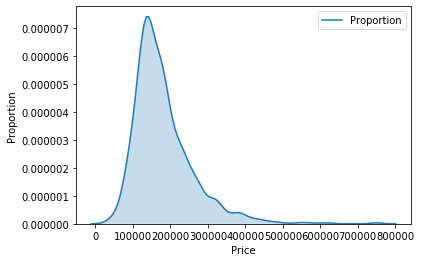

In [4]:
sns.kdeplot(df_data['SalePrice'], shade=True)
plt.legend(['Proportion'])
plt.ylabel('Proportion')
plt.xlabel('Price')

### 1.1.2. Categorical Variable - Price3Classes

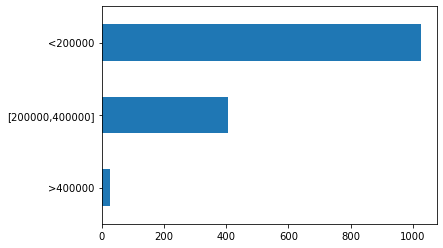

In [5]:
df_data.Price3Classes.value_counts().sort_values().plot(kind = 'barh')

We can see that we have an unbalanced dataset for the classification task.

### 1.1.3. Feature Exploration

Bellow we will define two vectors that saves the categorical and continuous variables that we identified by analysing the dataset. 

In [6]:
cat_var = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'MoSold',
    'SaleType',
    'SaleCondition'
]

num_var = [
    'LotFrontage',
    'LotArea',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',    
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'YrSold',
]

Now lets create a dataframe with information about the columns of the dataset. The dataframe have the following columns:

+ column: indicates the columns name;
+ type: indicates if the column is categorical or continuous
* data_type: the data type of the column;
* max: if the column is a continuous variable, the maximum of that column;
* min: if the column is a continuous variable, the minimum of that column;
* mean: if the column is a continuous variable, the mean of that column;
* std: if the column is a continuous variable, the standard deviation of that column;
* nulls_count: the number of records with that column being null;
* nulls_percentage: the percentage of nulls of that column;
* unique_count: the number of unique rows;
* zero_count: the number of records with zero.

In [7]:
all_columns = cat_var + num_var
template_df = list()

df_var_columns = [
    'column',
    'type',
    'data_type',
    'max',
    'min',
    'mean',
    'std',
    'nulls_count',
    'nulls_percentage',
    'unique_count',
    'zero_count',
]

for s in all_columns:
    template_df.append([s]+['']*(len(df_var_columns)-1))

df_variables_info = pd.DataFrame(template_df, columns=df_var_columns).set_index('column')

In [8]:
empty_df = []
total_rows = len(df_data)

for s in df_data.loc[:,'MSSubClass':'SaleCondition'].columns:

    nullable_values = len(df_data[s][df_data[s].isnull()])
    df_variables_info.loc[s, 'nulls_count'] = nullable_values
    df_variables_info.loc[s, 'nulls_percentage'] = (nullable_values/total_rows) * 100
    df_variables_info.loc[s, 'data_type'] = df_data[s].dtype
    df_variables_info.loc[s, 'unique_count'] = len(df_data[s].unique())
    #add column zero_count for features with dtype int64 or float64
    if (df_data[s].dtype == np.int64) | (df_data[s].dtype == np.float64) : 
        df_variables_info.loc[s, 'zero_count'] = len(df_data[df_data[s] == 0])
    if s in cat_var: df_variables_info.loc[s, 'type'] = 'categorical'
    elif s in num_var: 
        df_variables_info.loc[s, 'type'] = 'numerical'
        df_describe = df_data[s].describe().to_frame()
        df_variables_info.loc[s, 'mean'] = df_describe.loc['mean',s]
        df_variables_info.loc[s, 'std'] = df_describe.loc['std',s]
        df_variables_info.loc[s, 'min'] = df_describe.loc['min',s]
        df_variables_info.loc[s, 'max'] = df_describe.loc['max',s]
df_variables_info = df_variables_info.reset_index()

In [9]:
df_variables_info

,column,type,data_type,max,min,mean,std,nulls_count,nulls_percentage,unique_count,zero_count
0,MSSubClass,categorical,int64,,,,,0,0,15,0
1,MSZoning,categorical,object,,,,,0,0,5,
2,Street,categorical,object,,,,,0,0,2,
3,Alley,categorical,object,,,,,1369,93.7671,3,
4,LotShape,categorical,object,,,,,0,0,4,
...,...,...,...,...,...,...,...,...,...,...,...
74,3SsnPorch,numerical,int64,508,0,3.40959,29.3173,0,0,20,1436
75,ScreenPorch,numerical,int64,480,0,15.061,55.7574,0,0,76,1344
76,PoolArea,numerical,int64,738,0,2.7589,40.1773,0,0,8,1453
77,MiscVal,numerical,int64,15500,0,43.489,496.123,0,0,21,1408


Now lets do some analysis based on the dataframe defined above.

Lets explore the type of features that the dataset has.

Text(0.5, 1.0, 'Types of columns')

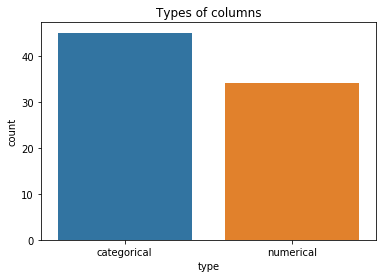

In [10]:
df_graph = df_variables_info.groupby('type').size().to_frame('count').reset_index()
sns.barplot(x='type',y='count', data = df_graph)
plt.title('Types of columns')

We can see that we have more categorical columns than numerical.

Now lets plot the percentage of nulls for each column

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

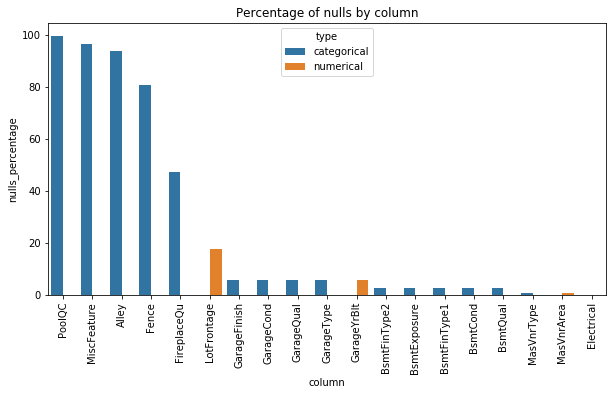

In [27]:
#get just columns with null values
df_graph = df_variables_info[df_variables_info['nulls_percentage']> 0].sort_values('nulls_percentage',ascending = False)
#plot them
plt.figure(figsize=(10,5))
sns.barplot(x='column', y = 'nulls_percentage', hue='type', data = df_graph)
plt.title('Percentage of nulls by column')
plt.xticks(rotation=90)

We can see that we have 5 categorical columns with with more than 50% of nulls, and just 3 continuous features with missing values.

Now lets analyse the amount of zeros by continuous column

C:\Users\joao_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

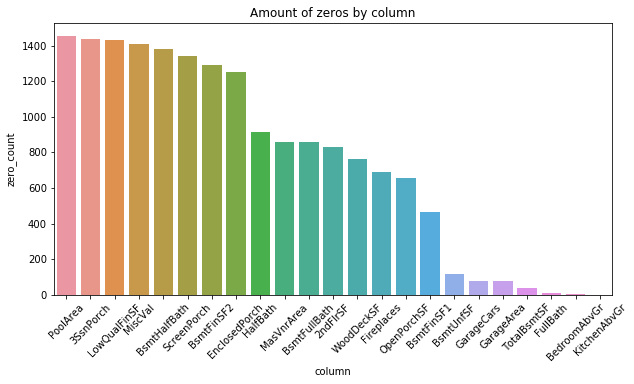

In [12]:
df_graph = df_variables_info[(df_variables_info['type'] == 'numerical') & (~df_variables_info['zero_count'].isnull())]
df_graph['zero_count'] = df_graph['zero_count'].astype(int)
df_graph = df_graph[df_graph['zero_count']>0].sort_values('zero_count',ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x='column',y='zero_count', data = df_graph)
plt.title('Amount of zeros by column')
plt.xticks(rotation=45)

In [13]:
df_data['PoolArea'].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

We have some features with a huge amount of zeros, but we consider that those features could be important in order to describe our target variables (the price of the house). For example, the feature PoolArea have most of his values being zero, but it is useful to describe the price of the houses, because a house with a pool is generally more expensive

## 1.2. Missing Values inputation

Numerical valued columns with missing values are:
+ Linear feet of street connected to property (LotFrontage), with almost 20% of nulls.
+ Masonry veneer area in square feet (MasVnrArea), with around 0.5% of nulls, just 8 records.
+ Year the garage was built (GarageYrBlt), with around 5.5% of nulls.

Bellow we define a function that will be used in order to analyse the feature distribution of that features.

In [14]:
def feature_dist(df, column_name):
    """"""
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

Lets analyse the distribution of 'LotFrontage' feature.

Records with missing values: 259

 mu = 70.05 and sigma = 24.27



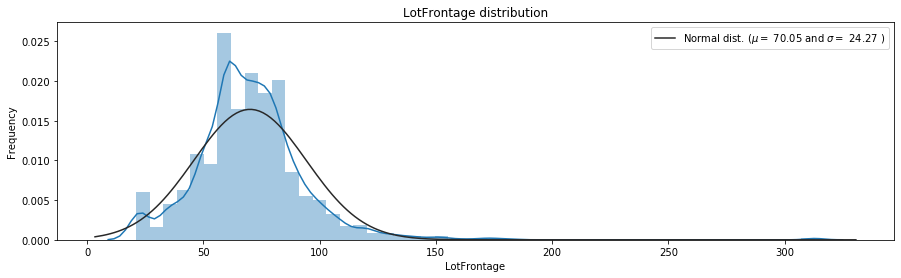

In [15]:
print('Records with missing values: {}'.format(len(df_data[df_data['LotFrontage'].isnull()])))
df_graph = df_data[df_data['LotFrontage']>=0]
feature_dist(df_graph, 'LotFrontage')

By analysing the graph above we can see that the feature distribution is similar to a gaussian distribution, with a mean of 70.05 and a standard deviation of 24.27. Because of that, we decided to input the mean to the missing values.

In [26]:
df_lotfrontagenulls = df_data[df_data['LotFrontage'].isnull()]
m = df_data['LotFrontage'].mean()
for i, r in df_lotfrontagenulls.iterrows():
    df_data.loc[i,'LotFrontage'] = m

Now lets analyse the distribution of 'MasVnrArea' feature.

Records with missing values: 8

 mu = 103.69 and sigma = 181.00



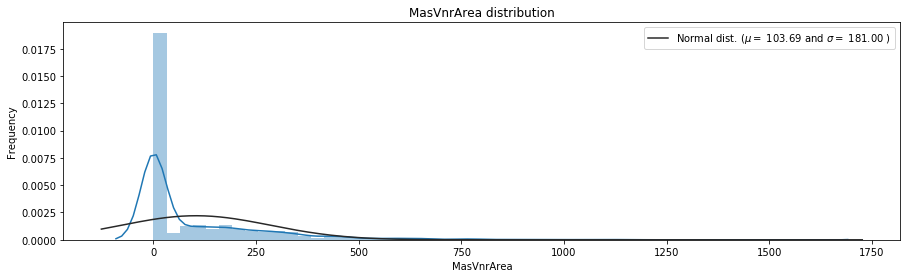

In [16]:
print('Records with missing values: {}'.format(len(df_data[df_data['MasVnrArea'].isnull()])))
df_graph = df_data[df_data['MasVnrArea']>=0]
feature_dist(df_graph, 'MasVnrArea')

Now lets explore the 'GarageYrBlt' feature distribution

Records with missing values: 81

 mu = 1978.51 and sigma = 24.68



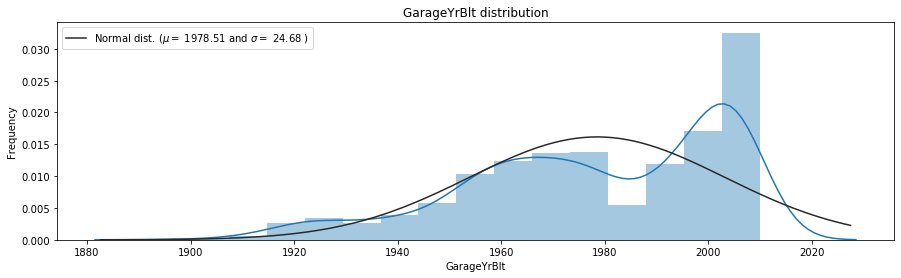

In [17]:
print('Records with missing values: {}'.format(len(df_data[df_data['GarageYrBlt'].isnull()])))
df_graph = df_data[df_data['GarageYrBlt']>=0]
feature_dist(df_graph, 'GarageYrBlt')

The feature has a mean around 1980 and a standard deviation of 25. We could assign the missing values with the mean of the feature, but we decided to assign it with the same value as the 'YearBuilt', which represents the year that the house was built. This prevent us from having cases were GarageYrBlt < YearBuilt

In [21]:
df_garageyearnulls = df_data[df_data['GarageYrBlt'].isnull()]
for i, r in df_garageyearnulls.iterrows():
    df_data.loc[i,'GarageYrBlt'] = r.YearBuilt

Categorical columns with missing values are a lot more, they include:
+ Type of alley access (Alley)
+ Masonry veneer type (MasVnrType)
+ Height of the basement (BsmtQual)
+ General condition of the Basement (BsmtCond)
+ Walkout of garden level basement walls (BsmtExposure)
+ Quality of basement finished area (BsmtFinType1)
+ Quality of second finished area (BsmtFinType2)
+ Electrical System (Electrical)
+ Fireplace quality (FireplaceQu)
+ Garage location (GarageType)
+ Interior finish of the garage (GarageFinish)
+ Garage quality (GarageQual)
+ Garage condition (GarageCond)
+ Pool quality (PoolQC)
+ Fence quality (Fence)
+ Miscellaneous feature not covered in other categories (MiscFeature)

The columns defined bellow are the categorical columns that have most of his values being null, as we have seen in the previous section. We decided to remove that columns from the dataset.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

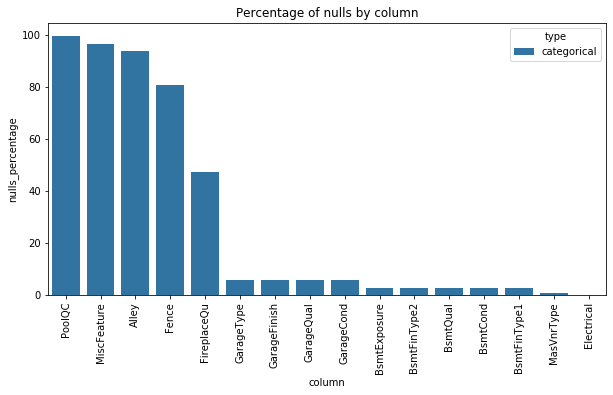

In [47]:
#get just columns with null values
df_graph = df_variables_info[(df_variables_info['nulls_percentage']> 0)&(df_variables_info['type']=='categorical')].sort_values('nulls_percentage',ascending = False)
#plot them
plt.figure(figsize=(10,5))
sns.barplot(x='column', y = 'nulls_percentage', hue='type', data = df_graph)
plt.title('Percentage of nulls by column')
plt.xticks(rotation=90)

In [33]:
cols_to_remove = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu'
]
for c in cols_to_remove: df_data.drop(c, axis=1, inplace=True)

For the other categorical columns we will input 'unknown' since it is impossible to know if the missing data was forgotten to be added or if it was just because it was not applicable. Beside that, these remaining categorical features have few values 

In [46]:
cat_var2 = np.setdiff1d(cat_var,cols_to_remove)
# yields the elements in `list_2` that are NOT in `list_1`
df_data[cat_var2] = df_data[cat_var2].fillna('unknown')

## 1.3. Feature Selection

As the number of features increases, the model becomes more complex. The more the number of features, the more the chances of overfitting. A machine learning model that is trained on a large number of features, gets increasingly dependent on the data it was trained on and in turn becomes overfitted, resulting in poor performance on real data, beating its purpose.

We therefore do a dimensionality reduction. But before we do it, we must encode the categorical columns.

### 1.3.1 Features encoding
Here we define two methods that we will use during the notebook, to encode categorical features:

* int_encode_feature, that is used in handling categorical features with two values;
* ohenc_encode_feature,that uses One Hot Encoding, and it is used to handle categorical features with more than two values.

In [15]:
def get_data(df, features=None, regression=True):
    """Creates data.
    
    Parameters:
        df (DataFrame): table with rows and columns
        features (Index, Series, list): vector of column names to include in data
        binary (bool): choose which target values to use
    
    Returns:
        ndarray: matrix of features values
        ndarray: vector of target values
        ndarray, Index, list: vector of feature names
        string: target name
    
    """
    if features is None: 
        features = df.columns.tolist()
    
    # guarantee that target features are not included
        features.remove('Id')
        features.remove('Price3Classes')
        features.remove('SalePrice')
    
    X = df[features]
    
    if regression == True:
        y = df[['SalePrice']]
        target = 'SalePrice'
    else:
        y = df[['Price3Classes']]
        target = 'Price3Classes'
    
    return X, y, features, target

In [16]:
def int_encode_feature(vect):
    enc = LabelEncoder()
    label_encoder = enc.fit(vect)
    integer_classes = label_encoder.transform(label_encoder.classes_)
    t = label_encoder.transform(vect)
    return t

#ONE HOT ENCODER METHOD FROM TP05 CLASS

#For categorical features with more than two possible values, a different approach is used. 
#The idea is to encode each possible value as a distinct feature, using the so-called one-hot-encoding.

#We start by defining the function ohenc_encode_feature that given a target column (col), 
#the number of rows (nrow) and the number of possible values (ndim), replaces the original column by ndim new binary colums.


def ohenc_encode_feature(table_X, col, nrow, ndim, columns, column_to_encode):
    enc = LabelEncoder()
    label_encoder = enc.fit(table_X[:, col])
    integer_classes = label_encoder.transform(label_encoder.classes_).reshape(ndim, 1)
    enc = OneHotEncoder()
    one_hot_encoder = enc.fit(integer_classes)
    # First, convert feature values to 0-(N-1) integers using label_encoder
    num_of_rows = nrow
    t = label_encoder.transform(table_X[:, col]).reshape(num_of_rows, 1)
    # Second, create a sparse matrix with col columns, each one indicating
    # whether the instance belongs to the class
    new_features = one_hot_encoder.transform(t)
    new_features_names = enc.get_feature_names([column_to_encode])
    columns.remove(column_to_encode)
    columns.extend(new_features_names)
    # Add the new features to table_X
    table_X = np.concatenate([table_X, new_features.toarray()], axis = 1)
    # Eliminate converted columns
    table_X = np.delete(table_X, [col], 1)
    return new_features_names,  pd.DataFrame(table_X, columns= columns)

def binary_encode_columns(df, cols):
    for c in cols:
        column_index = df.columns.get_loc(c)
        df[c] = int_encode_feature(df[c].values)
        df[c] = df[c].astype(float)
    return df

def one_hot_encoding_columns(df, cols_to_encode):
    columns = list(df)
    num_of_rows = len(df)
    for c in cols_to_encode:
        column_index = df.columns.get_loc(c)
        num_uniques = len(list(df[c].unique()))
        new_columns_names, df = ohenc_encode_feature(df.values, column_index, num_of_rows, num_uniques, columns, c)
        df[new_columns_names] = df[new_columns_names].astype(float)
    return df

In [17]:
df_X, df_y_reg, features, target = get_data(df_data, regression=True)
df_X, df_y_cat, features, target = get_data(df_data, regression=False)
df_X = one_hot_encoding_columns(df_X, cat_var)
df_X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,65,8450,7,5,2003,2003,196,706,0,150,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0
1,80,9600,6,8,1976,1976,0,978,0,284,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0
2,68,11250,7,5,2001,2002,162,486,0,434,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0
3,60,9550,7,5,1915,1970,0,216,0,540,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
4,84,14260,8,5,2000,2000,350,655,0,490,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0


### 1.3.2. Feature Selection

#### For Regression

In [18]:
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(df_X, df_y_reg)

/home/gustavosf/Documents/GitHub/DataMining-Project-3/dm-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=500, random_state=1)

Text(0, 0.5, 'Importance')

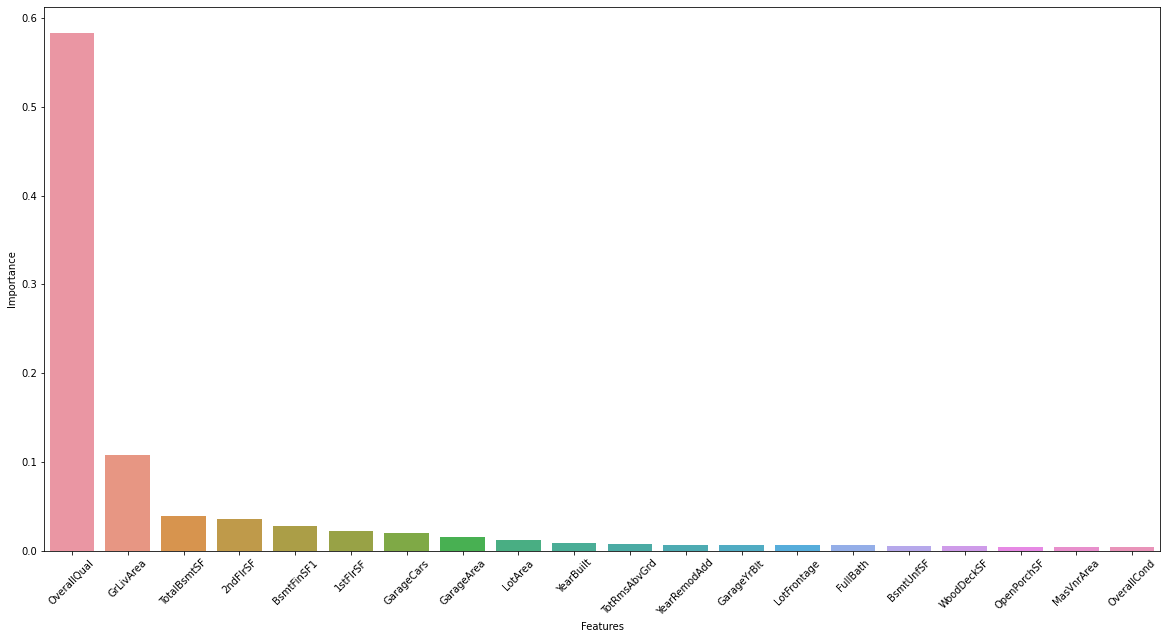

In [19]:
importance_df = pd.DataFrame(np.vstack((df_X.columns,model.feature_importances_))).T.sort_values(1, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data=importance_df.iloc[:20,:], x=0, y=1)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')

In [20]:
# Saving the column for Regression analysis

reg_columns = importance_df[0].head(20).values.tolist()

#### For Classification

In [21]:
model = RandomForestClassifier(n_estimators=500, random_state=1)
model.fit(df_X, df_y_cat)

/home/gustavosf/Documents/GitHub/DataMining-Project-3/dm-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=500, random_state=1)

Text(0, 0.5, 'Importance')

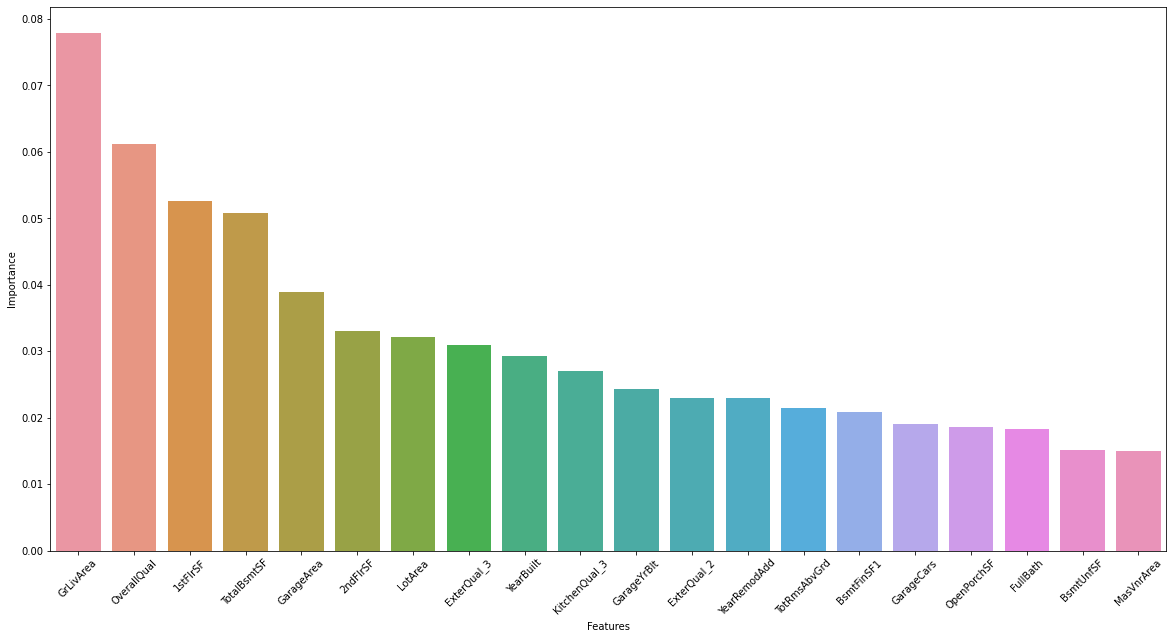

In [22]:
importance_df = pd.DataFrame(np.vstack((df_X.columns,model.feature_importances_))).T.sort_values(1, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data=importance_df.iloc[:20,:], x=0, y=1)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')

In [23]:
# Saving the column for Classification analysis

class_columns = importance_df[0].head(20).values.tolist()

## Balancing Data

### For Classification

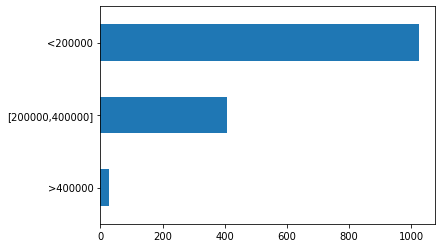

In [24]:
df_y_cat.Price3Classes.value_counts().sort_values().plot(kind = 'barh')

In [25]:
smt = SMOTETomek(random_state=1)
X_res, y_res = smt.fit_resample(df_X[class_columns], df_y_cat['Price3Classes'])

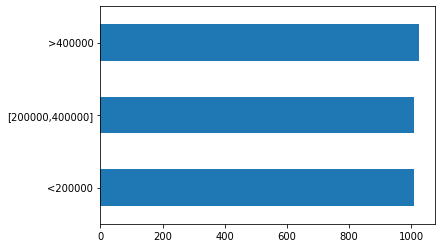

In [26]:
y_res.value_counts().sort_values().plot(kind = 'barh')

In [51]:
X_res['Price3Classes'] = y_res

# Save/Load data
df_path_class = 'data/data_class.csv'

if not os.path.isfile(df_path):
    X_res.to_csv(df_path, header=True, index=False)

### For Regression

Text(0.5, 0, 'Price')

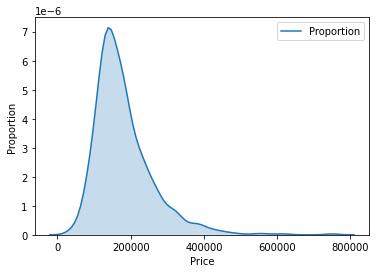

In [27]:
sns.kdeplot(df_data['SalePrice'], shade=True)
plt.legend(['Proportion'])
plt.ylabel('Proportion')
plt.xlabel('Price')

In [28]:
df2 = pd.read_csv('data/ModifiedHousePrices.csv')
df_X_reg = df2[reg_columns].fillna(-1)

In [29]:
df_X_reg['SalePrice'] = df_y_reg['SalePrice']
df_data_reg = smogn.smoter(data=df_X_reg, y='SalePrice')

r_index: 100%|##########| 84/84 [00:00<00:00, 551.08it/s]


Text(0.5, 0, 'Price')

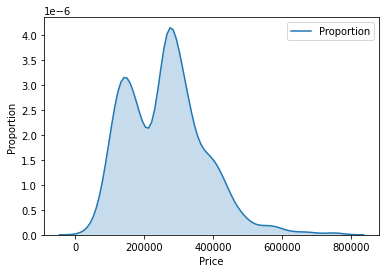

In [30]:
sns.kdeplot(df_data_reg['SalePrice'], shade=True)
plt.legend(['Proportion'])
plt.ylabel('Proportion')
plt.xlabel('Price')

In [40]:
# Save/Load data
df_path_reg = 'data/data_reg.csv'

if not os.path.isfile(df_path):
    df_data_reg.to_csv(df_path, header=True, index=False)

## 2. Learning Simple Classifiers

* Choose **`X` classifiers** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and stratified 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Present mean and standard deviation of accuracy, precision and recall.
* Show confusion matrices.

In [53]:
df_path_class = 'data/data_class.csv'
df_data_class = pd.read_csv(df_path_class)

In [70]:
# X,y data
X_class = df_data_class.iloc[:,:-1]
y_class = df_data_class[['Price3Classes']]

In [72]:
X_class.head()

,GrLivArea,OverallQual,1stFlrSF,TotalBsmtSF,GarageArea,2ndFlrSF,LotArea,ExterQual_3,YearBuilt,KitchenQual_3,GarageYrBlt,ExterQual_2,YearRemodAdd,TotRmsAbvGrd,BsmtFinSF1,GarageCars,OpenPorchSF,FullBath,BsmtUnfSF,MasVnrArea
0,1710.0,7.0,856.0,856.0,548.0,854.0,8450.0,0.0,2003.0,0.0,2003.0,1.0,2003.0,8.0,706.0,2.0,61.0,2.0,150.0,196.0
1,1262.0,6.0,1262.0,1262.0,460.0,0.0,9600.0,1.0,1976.0,1.0,1976.0,0.0,1976.0,6.0,978.0,2.0,0.0,2.0,284.0,0.0
2,1786.0,7.0,920.0,920.0,608.0,866.0,11250.0,0.0,2001.0,0.0,2001.0,1.0,2002.0,6.0,486.0,2.0,42.0,2.0,434.0,162.0
3,1717.0,7.0,961.0,756.0,642.0,756.0,9550.0,1.0,1915.0,0.0,1998.0,0.0,1970.0,7.0,216.0,3.0,35.0,1.0,540.0,0.0
4,2198.0,8.0,1145.0,1145.0,836.0,1053.0,14260.0,0.0,2000.0,0.0,2000.0,1.0,2000.0,9.0,655.0,3.0,84.0,2.0,490.0,350.0


## 3. Learning Simple Regressors

* Choose **`X` regressors** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Use the mean absolute error regression loss, or other relevant metrics.

In [ ]:
# Present and Discuss your results here
# ...

## 4. Ensemble Learning

### Voting Classifier/Regressor

* Use a voting classifier (http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)/regressor(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) to combine the best results of the `X` classifiers/regressors from previous sections. 

In [ ]:
# Present and Discuss your results here
# ...

### XGBoost 

* Use [XGBoost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn).

In [ ]:
# Present and Discuss your results here
# ...

### Random Forests

* Use [Random Forests](http://scikit-learn.org/stable/modules/ensemble.html#random-forests).

In [ ]:
# Present and Discuss your results here
# ...